# Twitter Sentiment Analysis of iPhone 13 Release

### Author: Justin Weible

## Business Case

The iPhone 13 is Apple's latest model, released on September 24, 2021.

Twitter has become a medium where people freely express their thoughts and opinions on a wide variety of topics, including recent product releases like iPhone 13.

The purpose of this analysis is to look at tweets about the iPhone 13, determine if the tweet is positive, negative, or neutral, and then use this information to determine the public’s response to various iPhone features.

This information can be used to analyze how consumers respond to the key features of iPhone 13 to be used by marketing and product development in order to identify improvements that could be highlighted for future iPhone models.

## Data Collection

The dataset was sourced from Twitter and obtained via Twint.

These tweets were collected over a two-week period from September 26, 2021, to October 9, 2021, coinciding with the two-week period following the release of the iPhone 13 on September 24.

An overall total of 129,344 tweets were collected from Twitter encompassing all languages, but the number of tweets was reduced to 63,799 tweets to include only the tweets in English.

Tweets were collected starting on September 26, two days after the product release, in order to account for sales over opening weekend and to allow more consumers to have hands-on experience with the product.

Twint allows CSVs to be created with specific columns, so the columns that were chose were ID, Date, Time, Tweet, and Language.

The Date and Time columns were then merged into one column called date_time and then exported into a new CSV file to be used in a separate notebook.

In [1]:
import pandas as pd
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import datetime

#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.metrics import plot_confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from functions import all_models as m
from functions import plot_importances
from functions import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('csv/iPhoneTweets.csv')

In [3]:
df.head()

id       date      time  \
0  1.440000e+18  9/26/2021  10:23:04   
1  1.440000e+18  9/26/2021  10:23:04   
2  1.440000e+18  9/26/2021  10:22:51   
3  1.440000e+18  9/26/2021  10:22:28   
4  1.440000e+18  9/26/2021  10:22:09   

                                               tweet language  
0  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...       en  
1                     I kind of want the iPhone 13 🤔       en  
2  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...       en  
3  iphone 13 is another huge distraction from the...       en  
4  @TrollTheMagic I know you are going to buy iPh...       en

In [4]:
df = df[df['language'] == "en"]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63778 entries, 0 to 125584
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        63778 non-null  float64
 1   date      63778 non-null  object 
 2   time      63778 non-null  object 
 3   tweet     63778 non-null  object 
 4   language  63778 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.9+ MB


In [6]:
df.isna().sum()

id          0
date        0
time        0
tweet       0
language    0
dtype: int64

In [7]:
df['language'].value_counts()

en    63778
Name: language, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63778 entries, 0 to 125584
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        63778 non-null  float64
 1   date      63778 non-null  object 
 2   time      63778 non-null  object 
 3   tweet     63778 non-null  object 
 4   language  63778 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.9+ MB


In [9]:
df['date_time'] = df['date'].str.cat(df['time'],sep=" ")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63778 entries, 0 to 125584
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         63778 non-null  float64
 1   date       63778 non-null  object 
 2   time       63778 non-null  object 
 3   tweet      63778 non-null  object 
 4   language   63778 non-null  object 
 5   date_time  63778 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.4+ MB


In [11]:
df = df[['id', 'tweet', 'language', 'date_time']]

## Data Cleaning and Lemmatization

The first step in data cleaning was to convert the 'data_time' column into datetime format for future visualizations and analysis.

Two functions were created for lemmatization.

The first function adds a whitespace to the end of every tweet in order to separate them and removes all web links and special characters.
It then puts all tweets in lowercase before tokenizing each tweet and removing all the stopwords.

The second function attaches a POS tag to each tokenized word before lemmatizing each tweet.

An additonal column labeled 'clean_tweet' was created with just the lemmatized words.

In [12]:
tweets = pd.read_csv('csv/iPhoneTweets_en.csv')
tweets.head()

id                                              tweet language  \
0  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...       en   
1  1.440000e+18                     I kind of want the iPhone 13 🤔       en   
2  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...       en   
3  1.440000e+18  iphone 13 is another huge distraction from the...       en   
4  1.440000e+18  @TrollTheMagic I know you are going to buy iPh...       en   

            date_time  
0  9/26/2021 10:23:04  
1  9/26/2021 10:23:04  
2  9/26/2021 10:22:51  
3  9/26/2021 10:22:28  
4  9/26/2021 10:22:09

In [13]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63778 entries, 0 to 63777
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         63778 non-null  float64
 1   tweet      63778 non-null  object 
 2   language   63778 non-null  object 
 3   date_time  63778 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [14]:
tweets.date_time = pd.to_datetime(tweets.date_time)

In [15]:
tweets[tweets.duplicated()]

id                                              tweet  \
41323  1.450000e+18  tell me why i ordered the new iphone 13 and it...   
41324  1.450000e+18  i sold my soul for the iphone 12 and this ipho...   
41325  1.450000e+18  iPhone 13 Pro &amp; Pro Max Review: The Ultima...   
41326  1.450000e+18  Just checked my new iPhone 13 Pro’s battery li...   
41327  1.450000e+18                                        iPhone 13 ✅   
...             ...                                                ...   
57205  1.450000e+18    stop calling and ask for iPhone 13 stock please   
57206  1.450000e+18  iPhone 13 Pro &amp; Pro Max review: The ultima...   
57207  1.450000e+18                             The IPhone 13 is 🔥🔥🔥🔥🔥   
57208  1.450000e+18  Get the new iPhone 13 from @plentygadgets  iPh...   
57209  1.450000e+18   iPhone 13 Pro  DualSense &amp; PlayStation R...   

      language           date_time  
41323       en 2021-10-05 19:59:38  
41324       en 2021-10-05 19:59:13  
41325       en 2021-10-05 19:58:16  
41326       en 2021-10-05 19:57:04  
41327       en 2021-10-05 19:57:02  
...        ...                 ...  
57205       en 2021-10-07 00:01:33  
57206       en 2021-10-07 00:00:50  
57207       en 2021-10-07 00:00:33  
57208       en 2021-10-07 00:00:07  
57209       en 2021-10-07 00:00:01  

[9383 rows x 4 columns]

In [16]:
def clean_tweets(dataframe):
    # Add whitespace to the end of every tweet
    dataframe['clean_tweet'] = dataframe.tweet.map(lambda x: x + " ") 

    # Remove http links
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: re.sub(r'http.*', '', x))
    
    # Remove special characters and numbers
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: re.sub(r"[^a-zA-Z#]", ' ', x))
    
    # Lowercase all tweets
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.lower())
    
    #Tokenize tweets and remove stop words
    stopword_list = stopwords.words('english')
    for i in range(len(dataframe.clean_tweet)):
        tokens = word_tokenize(dataframe.clean_tweet[i])
        clean_tokens = [w for w in tokens if w not in stopword_list]
        dataframe.clean_tweet[i] = clean_tokens

In [17]:
clean_tweets(tweets)
tweets.head()

id                                              tweet language  \
0  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...       en   
1  1.440000e+18                     I kind of want the iPhone 13 🤔       en   
2  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...       en   
3  1.440000e+18  iphone 13 is another huge distraction from the...       en   
4  1.440000e+18  @TrollTheMagic I know you are going to buy iPh...       en   

            date_time                                        clean_tweet  
0 2021-09-26 10:23:04                             [tg, iphone, giveaway]  
1 2021-09-26 10:23:04                               [kind, want, iphone]  
2 2021-09-26 10:22:51                             [tg, iphone, giveaway]  
3 2021-09-26 10:22:28  [iphone, another, huge, distraction, enemy, be...  
4 2021-09-26 10:22:09  [trollthemagic, know, going, buy, iphone, pro,...

In [18]:
tweets.clean_tweet[4]

['trollthemagic', 'know', 'going', 'buy', 'iphone', 'pro', 'max']

In [19]:
def lemmatize_tweet(tweets):
    
    for i in range(len(tweets)):
        # Pos-tag each word in tweet
        for word in [tweets[i]]:
            pos_tag_list = nltk.pos_tag(word)
        # Convert pos-tag to be wordnet compliant
        wordnet_tags = []
        for j in pos_tag_list:
            # Adjective
            if j[1].startswith('J'):
                wordnet_tags.append(wordnet.ADJ)
            # Noun
            elif j[1].startswith('N'):
                wordnet_tags.append(wordnet.NOUN)
            # Adverb
            elif j[1].startswith('R'):
                wordnet_tags.append(wordnet.ADV)
            # Verb
            elif j[1].startswith('V'):
                wordnet_tags.append(wordnet.VERB)
            # Default to noun
            else:
                wordnet_tags.append(wordnet.NOUN)
        # Lemmatize each word in tweet
        lem_words = []
        for k in range(len(tweets[i])):
            lem_words.append(lemmatizer.lemmatize(tweets[i][k], pos=wordnet_tags[k]))
        lem_tweet = ' '.join(lem_words)
        tweets[i] = lem_tweet

In [20]:
lemmatize_tweet(tweets.clean_tweet)
tweets

id                                              tweet  \
0      1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...   
1      1.440000e+18                     I kind of want the iPhone 13 🤔   
2      1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...   
3      1.440000e+18  iphone 13 is another huge distraction from the...   
4      1.440000e+18  @TrollTheMagic I know you are going to buy iPh...   
...             ...                                                ...   
63773  1.450000e+18  there’s nothing substantially different I feel...   
63774  1.450000e+18  me distracting apple store employees with an i...   
63775  1.450000e+18                             iphone 13 or pixel 6 ?   
63776  1.450000e+18  55 percent just done after 1 days using iPhone...   
63777  1.450000e+18  iPhone 13. Your new superpower. Get iPhone 13 ...   

      language           date_time  \
0           en 2021-09-26 10:23:04   
1           en 2021-09-26 10:23:04   
2           en 2021-09-26 10:22:51   
3           en 2021-09-26 10:22:28   
4           en 2021-09-26 10:22:09   
...        ...                 ...   
63773       en 2021-10-09 00:01:32   
63774       en 2021-10-09 00:01:26   
63775       en 2021-10-09 00:00:55   
63776       en 2021-10-09 00:00:34   
63777       en 2021-10-09 00:00:03   

                                             clean_tweet  
0                                     tg iphone giveaway  
1                                       kind want iphone  
2                                     tg iphone giveaway  
3      iphone another huge distraction enemy well hum...  
4               trollthemagic know go buy iphone pro max  
...                                                  ...  
63773        nothing substantially different feel iphone  
63774  distract apple store employee iphone pro max m...  
63775                                       iphone pixel  
63776                  percent do day use iphone pro max  
63777  iphone new superpower get iphone instalment mo...  

[63778 rows x 5 columns]

In [21]:
tweets.clean_tweet[4]

'trollthemagic know go buy iphone pro max'

## Initial Frequency Distribution

An initial frequency distribution of the lemmatized tweets was created just to gauge what words were being seen and if any additional words, symbols, characters needed to also be removed before passing the dataset through VADER for sentiment analysis.

In [22]:
# Join all the tweets into a single string
all_words_string = ' '.join([tweet for tweet in tweets.clean_tweet])

# Make a list of all the words in the dataframe
all_words_list = all_words_string.split()

In [23]:
# Plot word frequency distribution of first few words

plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
plt.title('Intial Frequency Distribution')
freq_dist = nltk.FreqDist(all_words_list)
freq_dist.plot(25,cumulative=False)

<AxesSubplot:title={'center':'Intial Frequency Distribution'}, xlabel='Samples', ylabel='Counts'>

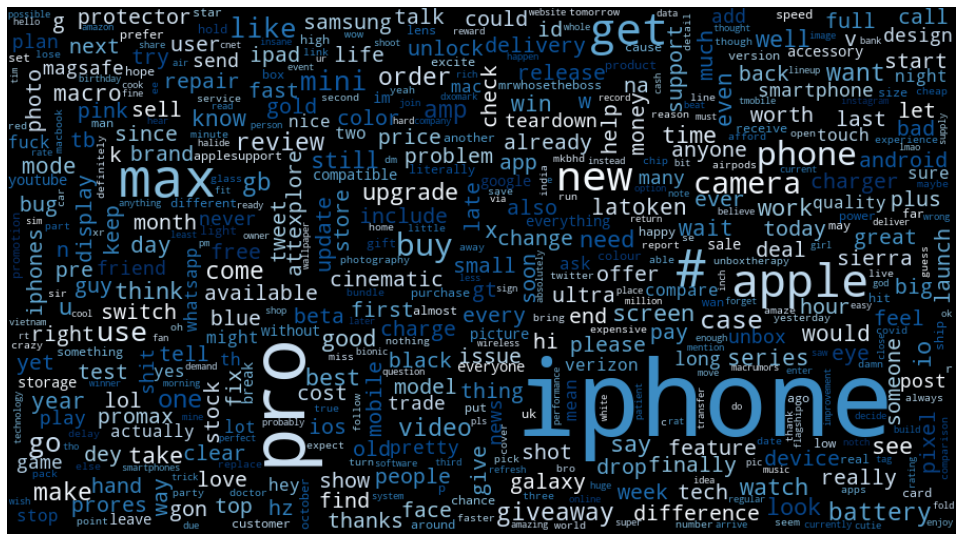

In [24]:
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(freq_dist)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Final Cleaning

The dataset was cleaned one more time, this time removing iPhone, Apple, the letter Q, and the hashtag symbol ahead of passing the dataframe through VADER sentiment analysis.

Another frequency distribution was created just to visualize the data.

In [25]:
# Remove iphone, apple, q, and #

def finish_cleaning(dataframe):
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('iphone',''))
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('apple',''))
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('q',''))
    dataframe.clean_tweet = dataframe.clean_tweet.map(lambda x: x.replace('#',''))

In [26]:
finish_cleaning(tweets)

In [27]:
# Join all the tweets into a single string
all_words_string = ' '.join([tweet for tweet in tweets.clean_tweet])

# Make a list of all the words in the dataframe
all_words_list = all_words_string.split()

# Plot word frequency distribution of first few words

plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
plt.title('Total Word Frequency Count')
freq_dist = nltk.FreqDist(all_words_list)
freq_dist.plot(25,cumulative=False)

<AxesSubplot:title={'center':'Total Word Frequency Count'}, xlabel='Samples', ylabel='Counts'>

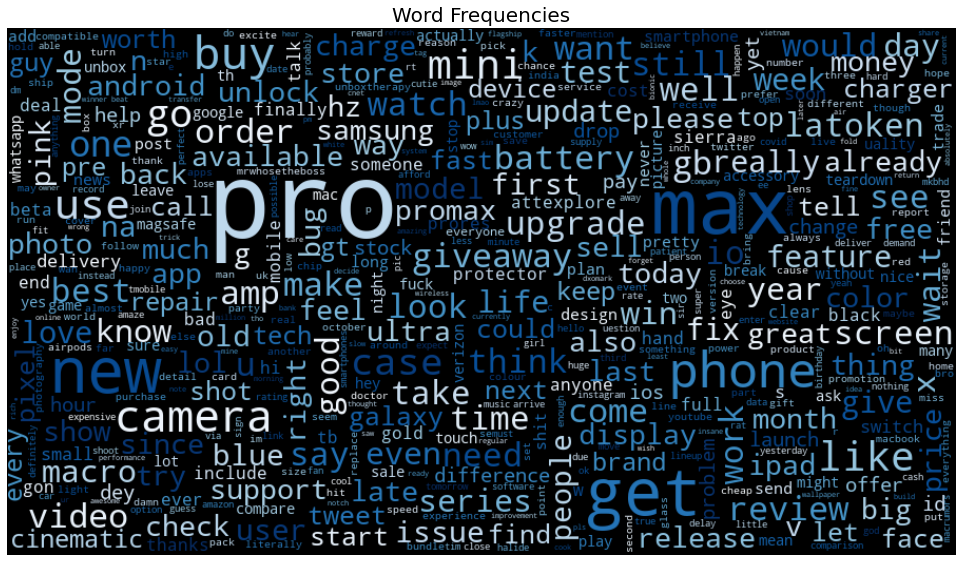

In [28]:
# Word Cloud with word frequencies

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(freq_dist)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Frequencies', fontsize=20)
plt.show()

## Initial Data Analysis

The initial data analysis looked at all the lemmatized words before sentiment analysis was performed.

Frequency distributions and graphs looked at the most popular words, the times of day when consumers were tweeting about the iPhone 13, specific days of the week when consumers were tweeting, and if there were specific days when consumers were tweeting more often about the product.

The purpose of this analysis was to look for trends in customer engagement, giving us a better idea of how many consumers were picking up phones in person versus online, how long shipping times were, and things like that.

In [29]:
word_freq = nltk.FreqDist(all_words_list)
freq_df = pd.DataFrame({'Word': list(word_freq.keys()), 'Count': list(word_freq.values())}).sort_values(by=['Count'], ascending=False)
freq_df.head(10)

Word  Count
18      pro  29969
19      max  14031
10      get   9328
104     new   8587
12    phone   5175
17      buy   4368
375  camera   4161
72      use   3678
44     like   3332
46     mini   3278

In [30]:
freq_df = freq_df.nlargest(columns="Count", n = 25) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=freq_df, x= "Word", y = "Count")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Word', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Most Popular Words", fontsize=20)
plt.show()

Dataframe grouping the number of tweets by hour of the day

In [31]:
hour_df = pd.DataFrame(tweets.groupby(tweets['date_time'].dt.hour)['clean_tweet'].count()).reset_index()
hour_df = hour_df.rename(columns={'date_time': 'Hour', 'clean_tweet': 'Count'})
hour_df.Hour = hour_df.Hour.replace([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0], ['12:00 AM', '1:00 AM', '2:00 AM', '3:00 AM', '4:00 AM', '5:00 AM', '6:00 AM', '7:00 AM', '8:00 AM', '9:00 AM', '10:00 AM', '11:00 AM', '12:00 AM', '1:00 PM', '2:00 PM', '3:00 PM', '4:00 PM', '5:00 PM', '6:00 PM', '7:00 PM', '8:00 PM', '9:00 PM', '10:00 PM', '11:00 PM'])
hour_df

Hour  Count
0   12:00 AM   2005
1    1:00 AM   1917
2    2:00 AM   2015
3    3:00 AM   2839
4    4:00 AM   2507
5    5:00 AM   2728
6    6:00 AM   2791
7    7:00 AM   3068
8    8:00 AM   3494
9    9:00 AM   3838
10  10:00 AM   3502
11  11:00 AM   3542
12  12:00 AM   3764
13   1:00 PM   3757
14   2:00 PM   3489
15   3:00 PM   3130
16   4:00 PM   2789
17   5:00 PM   2470
18   6:00 PM   2080
19   7:00 PM   1862
20   8:00 PM   1488
21   9:00 PM   1547
22  10:00 PM   1733
23  11:00 PM   1423

In [32]:
plt.figure(figsize=(16,5))
ax = sns.barplot(data=hour_df, x= "Hour", y = "Count")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Hour', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Tweets by Time of Day", fontsize=20)
plt.show()

Dataframe grouping the number of tweets by day

In [33]:
weekday_df = pd.DataFrame(tweets.groupby(tweets['date_time'].dt.weekday)['clean_tweet'].count()).reset_index()
weekday_df = weekday_df.rename(columns={'date_time': 'Day', 'clean_tweet': 'Count'})
weekday_df.Day = weekday_df.Day.replace([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
weekday_df

Day  Count
0     Monday   6764
1    Tuesday  11578
2  Wednesday  13502
3   Thursday  10575
4     Friday   8698
5   Saturday   6876
6     Sunday   5785

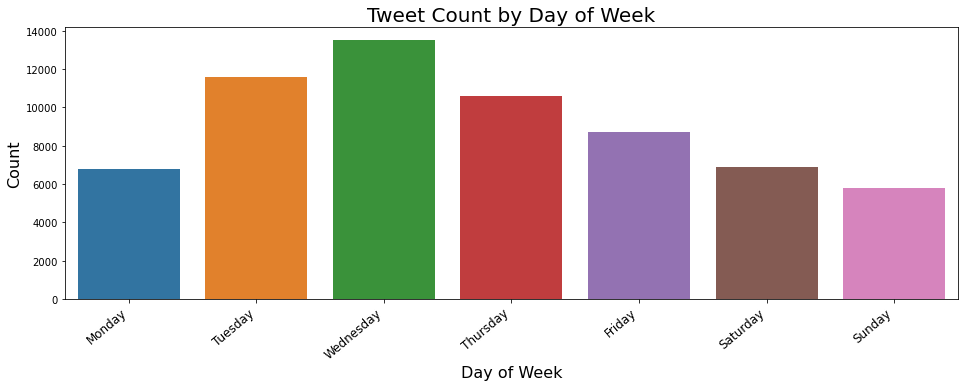

In [34]:
# Plot histogram of Tweet Counts by Day

plt.figure(figsize=(16,5))
ax = sns.barplot(data=weekday_df, x= "Day", y = "Count")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Day of Week', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Tweet Count by Day of Week", fontsize=20)
plt.show()

Dataframe grouping the number of tweets by day of the year

In [35]:
day_df = pd.DataFrame(tweets.resample('D', on='date_time')['clean_tweet'].count()).reset_index().sort_values(by='clean_tweet', ascending=False)
day_df = day_df.rename(columns={'date_time': 'Day', 'clean_tweet': 'Count'})
day_df.head()

Day  Count
10 2021-10-06   7490
9  2021-10-05   6874
3  2021-09-29   6012
4  2021-09-30   5366
5  2021-10-01   5223

In [36]:
top_tweeted_days = day_df.sort_values(by = 'Count', ascending=False)[:25]
top_tweeted_days

Day  Count
10 2021-10-06   7490
9  2021-10-05   6874
3  2021-09-29   6012
4  2021-09-30   5366
5  2021-10-01   5223
11 2021-10-07   5209
2  2021-09-28   4704
8  2021-10-04   3972
6  2021-10-02   3783
12 2021-10-08   3475
7  2021-10-03   3373
13 2021-10-09   3093
1  2021-09-27   2792
0  2021-09-26   2412

In [37]:
plt.figure(figsize=(16,5))
ax = sns.barplot(data=top_tweeted_days, x= top_tweeted_days.Day.dt.date, y = "Count")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Days with the Most Tweets", fontsize=20)
plt.show()

## VADER Sentiment

VADER sentiment analysis was then performed on the lemmatized dataset in order to classify each tweet as positive, negative, or neutral ahead of modeling.

A new column called 'Sentiment' was created that analyzed VADER's Compound score and gave it the proper classification (Positive, Negative, Neutral) based on each tweet's individual score.

An initial look at what words showed up in positive and negative tweets was done after VADER's analysis was complete, and wordclouds were generated for both positive and negative tweets.

In [38]:
df = pd.read_csv('csv/cleaned_tweets.csv').drop(['Unnamed: 0'],axis=1)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63778 entries, 0 to 63777
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           63778 non-null  float64
 1   tweet        63778 non-null  object 
 2   language     63778 non-null  object 
 3   date_time    63778 non-null  object 
 4   clean_tweet  62981 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.4+ MB


In [40]:
df.isna().sum()

id               0
tweet            0
language         0
date_time        0
clean_tweet    797
dtype: int64

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63778 entries, 0 to 63777
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           63778 non-null  float64
 1   tweet        63778 non-null  object 
 2   language     63778 non-null  object 
 3   date_time    63778 non-null  object 
 4   clean_tweet  62981 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.4+ MB


In [42]:
analyzer = SentimentIntensityAnalyzer()

scores = []
for sentence in df['tweet']:
  score = analyzer.polarity_scores(sentence)
  scores.append(score)
  
scores = pd.DataFrame(scores)

df['Compound'] = scores['compound']
df['Negative'] = scores['neg']
df['Neutral'] = scores['neu']
df['Positive'] = scores['pos']
df.head()

id                                              tweet language  \
0  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...       en   
1  1.440000e+18                     I kind of want the iPhone 13 🤔       en   
2  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...       en   
3  1.440000e+18  iphone 13 is another huge distraction from the...       en   
4  1.440000e+18  @TrollTheMagic I know you are going to buy iPh...       en   

             date_time                                        clean_tweet  \
0  2021-09-26 10:23:04                                       tg  giveaway   
1  2021-09-26 10:23:04                                         kind want    
2  2021-09-26 10:22:51                                       tg  giveaway   
3  2021-09-26 10:22:28   another huge distraction enemy well humble ge...   
4  2021-09-26 10:22:09                 trollthemagic know go buy  pro max   

   Compound  Negative  Neutral  Positive  
0    0.0000     0.000    1.000     0.000  
1    0.0772     0.000    0.794     0.206  
2    0.0000     0.000    1.000     0.000  
3   -0.2263     0.251    0.535     0.214  
4    0.0000     0.000    1.000     0.000

In [43]:
sentiment = []

for i in range(len(df)):
  if (df['Compound'][i] < 0):
    sentiment.append("Negative")
  elif (df['Compound'][i] > 0):
    sentiment.append("Positive")
  else:
    sentiment.append("Neutral")
    
sentiment = pd.DataFrame(sentiment)
df['Sentiment'] = sentiment
df.head()

id                                              tweet language  \
0  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/Wffx...       en   
1  1.440000e+18                     I kind of want the iPhone 13 🤔       en   
2  1.440000e+18  TG 13 iPhone 13 Giveaway!!!  https://t.co/LN1B...       en   
3  1.440000e+18  iphone 13 is another huge distraction from the...       en   
4  1.440000e+18  @TrollTheMagic I know you are going to buy iPh...       en   

             date_time                                        clean_tweet  \
0  2021-09-26 10:23:04                                       tg  giveaway   
1  2021-09-26 10:23:04                                         kind want    
2  2021-09-26 10:22:51                                       tg  giveaway   
3  2021-09-26 10:22:28   another huge distraction enemy well humble ge...   
4  2021-09-26 10:22:09                 trollthemagic know go buy  pro max   

   Compound  Negative  Neutral  Positive Sentiment  
0    0.0000     0.000    1.000     0.000   Neutral  
1    0.0772     0.000    0.794     0.206  Positive  
2    0.0000     0.000    1.000     0.000   Neutral  
3   -0.2263     0.251    0.535     0.214  Negative  
4    0.0000     0.000    1.000     0.000   Neutral

In [44]:
df.dropna(inplace=True)
df.isna().sum()

id             0
tweet          0
language       0
date_time      0
clean_tweet    0
Compound       0
Negative       0
Neutral        0
Positive       0
Sentiment      0
dtype: int64

In [45]:
# WordCloud for all words
all_words = ' '.join([text for text in df['clean_tweet']])

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate(all_words)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('All Words (Lemmatized)', fontsize=20)
plt.show()

In [46]:
negative_df = df[df['Sentiment'] == 'Negative']

In [47]:
negative_words = ' '.join([text for text in negative_df['clean_tweet']])

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate(all_words)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Words From Negative Tweets', fontsize=20)
plt.show()

In [48]:
positive_df = df[df['Sentiment'] == 'Positive']

In [49]:
positive_df.head()

id                                              tweet language  \
1   1.440000e+18                     I kind of want the iPhone 13 🤔       en   
9   1.440000e+18  Apple will fix iPhone 13 'Unlock with Apple Wa...       en   
11  1.440000e+18  iPhone 13 Unboxing 💙   Let’s see if this video...       en   
14  1.440000e+18  @TmarTn  I hope with this giveaway and much mo...       en   
19  1.440000e+18  Apple company shares crashes after iPhone 13 a...       en   

              date_time                                        clean_tweet  \
1   2021-09-26 10:23:04                                         kind want    
9   2021-09-26 10:21:33   fix  unlock  watch soon day silence sunday  c...   
11  2021-09-26 10:20:59        unboxing let see video well twitter like ig   
14  2021-09-26 10:20:24  tmartn hope giveaway much upcoming channel rea...   
19  2021-09-26 10:19:24                  company share crash  announcement   

    Compound  Negative  Neutral  Positive Sentiment  
1     0.0772     0.000    0.794     0.206  Positive  
9     0.2023     0.038    0.907     0.054  Positive  
11    0.5983     0.000    0.766     0.234  Positive  
14    0.8779     0.000    0.719     0.281  Positive  
19    0.2960     0.000    0.784     0.216  Positive

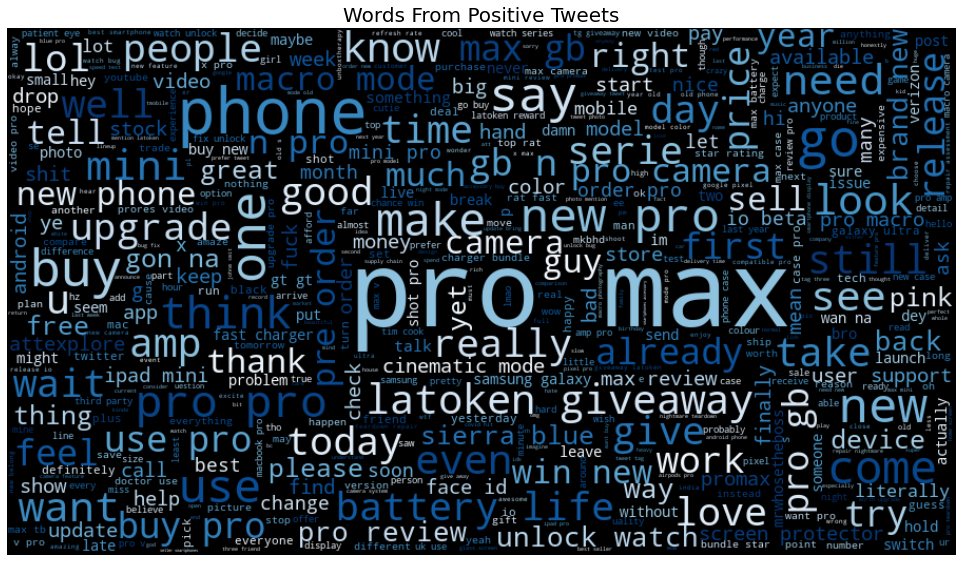

In [50]:
positive_words = ' '.join([text for text in positive_df['clean_tweet']])

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate(all_words)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Words From Positive Tweets', fontsize=20)
plt.show()

## Modeling

The new dataset was passed through a number of different models in order to find out which model performed the best overall and was the most balanced in terms of predicting whether a tweet was Positive, Negative, or Neutral.

Random Forest and Decision Tree both performed the best, with Random Forest just edging out Decision Tree in terms of overall accuracy.

However, both Random Forest and Decision Tree generated a number of false negatives and proved to be inaccurate when predicting negative tweets, despite both models predicting positive and netural tweets accurately.

This could be due to a class imbalance of the tweets, as there are  significantly more positive tweets in this dataset than negative ones.

Logistic Regression proved to be the best model at predicting negative tweets, so that is an option if you wanted to analyze just negative reactions.

In [51]:
df = pd.read_csv('csv/tweet_sentiment.csv').drop(['Unnamed: 0'],axis=1)

In [52]:
df = df[['tweet', 'clean_tweet', 'Sentiment']]

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62981 entries, 0 to 62980
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        62981 non-null  object
 1   clean_tweet  62981 non-null  object
 2   Sentiment    62981 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [54]:
df.Sentiment.value_counts()

Neutral     27062
Positive    26132
Negative     9787
Name: Sentiment, dtype: int64

In [55]:
plt.figure(figsize=(12,5))
df['Sentiment'].value_counts().plot(kind='pie', autopct="%.1f%%");
plt.title('Total Tweets', fontsize=20)
plt.show()

In [56]:
stop_words = stopwords.words('english')

x = df['clean_tweet']
y = df['Sentiment']

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=16)

In [58]:
vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern='[a-zA-Z0-9]+')
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [59]:
objects = [LogisticRegression(fit_intercept=False, C=1e12, solver='saga'), 
           Pipeline([('ss', StandardScaler(with_mean=False)), ('knn', KNeighborsClassifier())]),
           Pipeline([('bz', Binarizer()), ('bayes', MultinomialNB())]),
           Pipeline([('ss', StandardScaler(with_mean=False)), ('svm', SVC())]),
           DecisionTreeClassifier(), 
           RandomForestClassifier(), 
           GradientBoostingClassifier(),
           AdaBoostClassifier(),
           XGBClassifier(),
           CatBoostClassifier(verbose=False)]
index = ['Logistic Regression', 'Nearest Neighbors', 'Naive Bayes', 'SVM', 
         'Decision Tree', 'Random Forest', 'Gradient Boost', 'AdaBoost', 'XGBoost', 'CatBoost']

Logistic Regression Results:


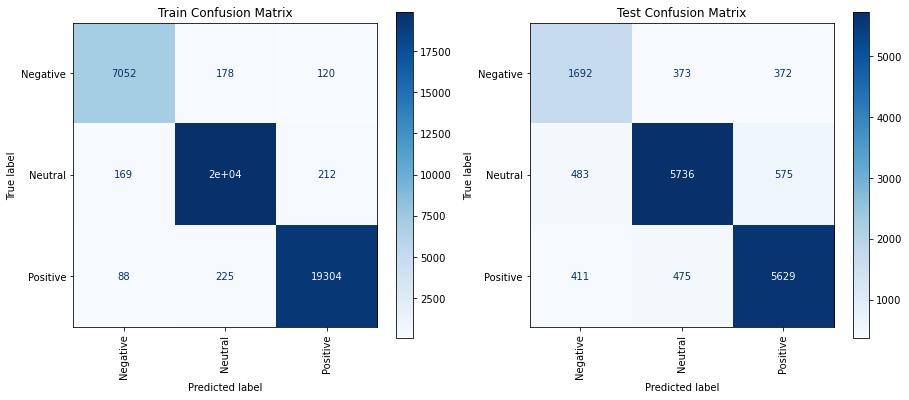

              precision    recall  f1-score   support

    Negative       0.65      0.69      0.67      2437
     Neutral       0.87      0.84      0.86      6794
    Positive       0.86      0.86      0.86      6515

    accuracy                           0.83     15746
   macro avg       0.79      0.80      0.80     15746
weighted avg       0.83      0.83      0.83     15746



Nearest Neighbors Results:


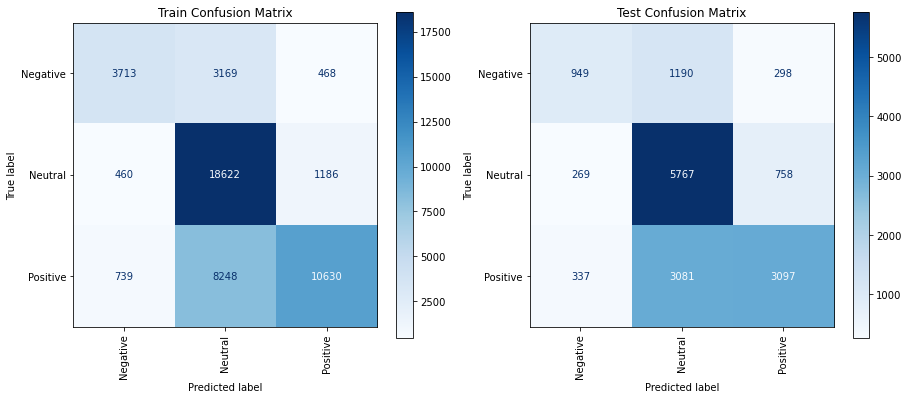

              precision    recall  f1-score   support

    Negative       0.61      0.39      0.48      2437
     Neutral       0.57      0.85      0.69      6794
    Positive       0.75      0.48      0.58      6515

    accuracy                           0.62     15746
   macro avg       0.64      0.57      0.58     15746
weighted avg       0.65      0.62      0.61     15746



Naive Bayes Results:


              precision    recall  f1-score   support

    Negative       0.71      0.55      0.62      2437
     Neutral       0.89      0.75      0.82      6794
    Positive       0.72      0.90      0.80      6515

    accuracy                           0.78     15746
   macro avg       0.78      0.74      0.75     15746
weighted avg       0.79      0.78      0.78     15746



SVM Results:


              precision    recall  f1-score   support

    Negative       0.86      0.50      0.63      2437
     Neutral       0.81      0.85      0.83      6794
    Positive       0.78      0.86      0.82      6515

    accuracy                           0.80     15746
   macro avg       0.81      0.74      0.76     15746
weighted avg       0.80      0.80      0.79     15746



Decision Tree Results:


              precision    recall  f1-score   support

    Negative       0.72      0.66      0.69      2437
     Neutral       0.88      0.91      0.90      6794
    Positive       0.88      0.87      0.87      6515

    accuracy                           0.86     15746
   macro avg       0.83      0.81      0.82     15746
weighted avg       0.85      0.86      0.86     15746



Random Forest Results:


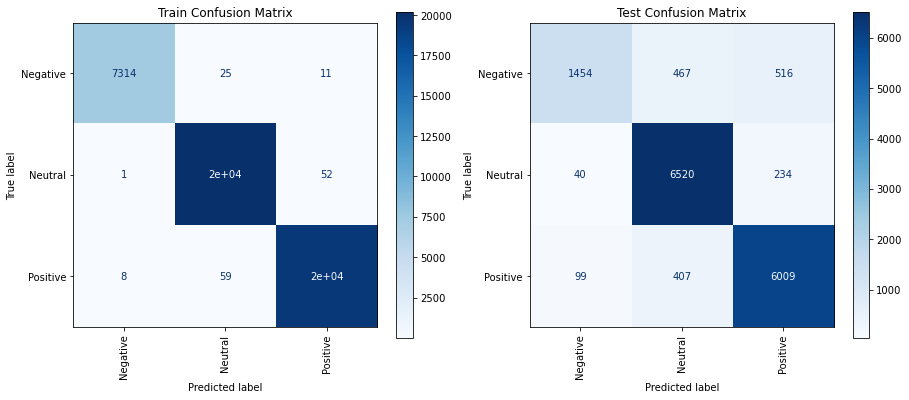

              precision    recall  f1-score   support

    Negative       0.91      0.60      0.72      2437
     Neutral       0.88      0.96      0.92      6794
    Positive       0.89      0.92      0.91      6515

    accuracy                           0.89     15746
   macro avg       0.89      0.83      0.85     15746
weighted avg       0.89      0.89      0.88     15746



Gradient Boost Results:


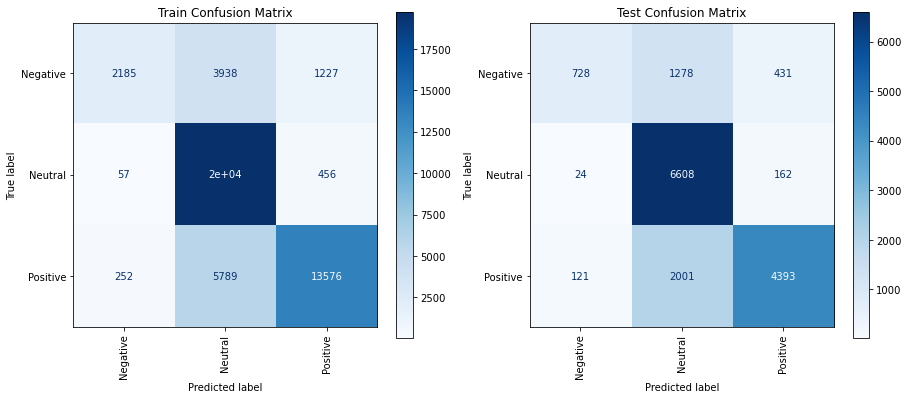

              precision    recall  f1-score   support

    Negative       0.83      0.30      0.44      2437
     Neutral       0.67      0.97      0.79      6794
    Positive       0.88      0.67      0.76      6515

    accuracy                           0.74     15746
   macro avg       0.79      0.65      0.67     15746
weighted avg       0.78      0.74      0.73     15746



AdaBoost Results:


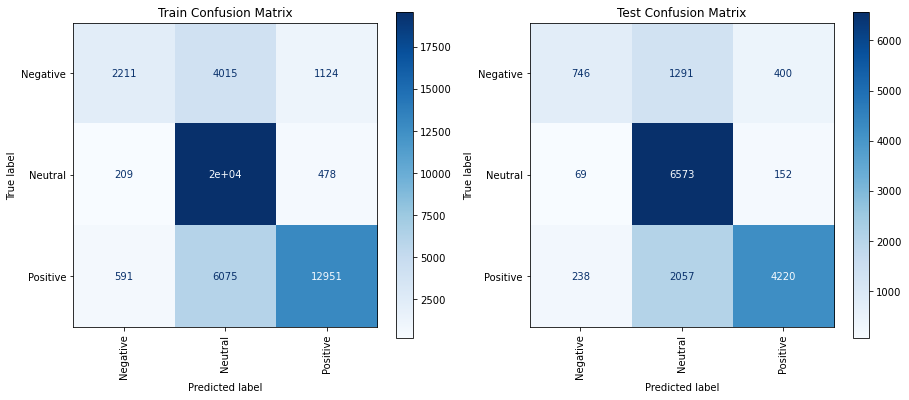

              precision    recall  f1-score   support

    Negative       0.71      0.31      0.43      2437
     Neutral       0.66      0.97      0.79      6794
    Positive       0.88      0.65      0.75      6515

    accuracy                           0.73     15746
   macro avg       0.75      0.64      0.65     15746
weighted avg       0.76      0.73      0.71     15746



XGBoost Results:
[23:07:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


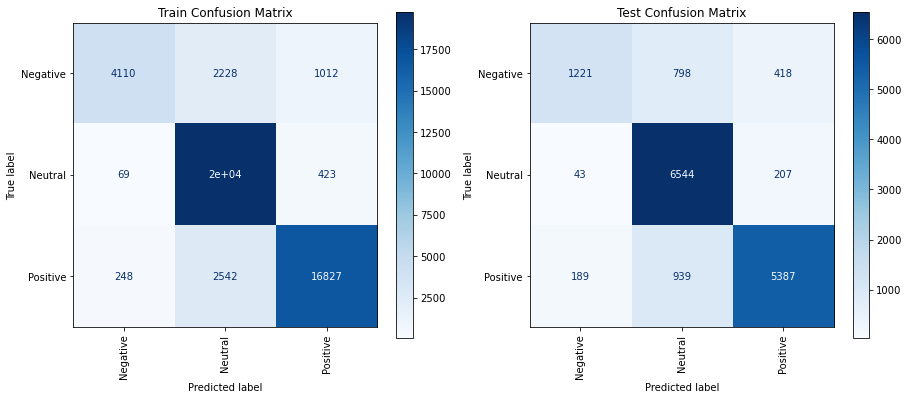

              precision    recall  f1-score   support

    Negative       0.84      0.50      0.63      2437
     Neutral       0.79      0.96      0.87      6794
    Positive       0.90      0.83      0.86      6515

    accuracy                           0.84     15746
   macro avg       0.84      0.76      0.79     15746
weighted avg       0.84      0.84      0.83     15746



CatBoost Results:


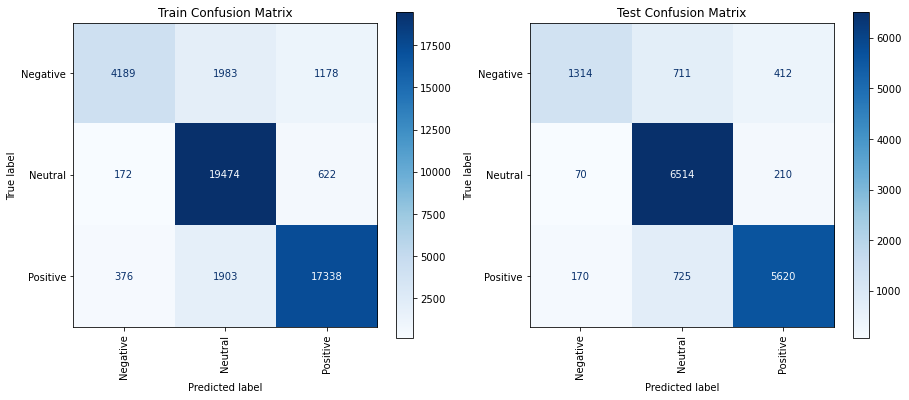

              precision    recall  f1-score   support

    Negative       0.85      0.54      0.66      2437
     Neutral       0.82      0.96      0.88      6794
    Positive       0.90      0.86      0.88      6515

    accuracy                           0.85     15746
   macro avg       0.86      0.79      0.81     15746
weighted avg       0.86      0.85      0.85     15746





The model with the highest precision score is Random Forest.
The model with the highest recall score is Random Forest.
The model with the highest accuracy score is Random Forest.
The model with the highest F1 score is Random Forest.


In [60]:
models = m(x_train, x_test, y_train, y_test, objects=objects, index=index)

## Feature Importances

Feature importances were looked at in order to see what words/features were influencing the model.

Because the model was influenced by a number of adjectives and nouns that weren't actual features of the iPhone itself, a list of key features of the iPhone were isolated in order to see how those specific features influenced the model.

Battery, display, camera, pro, max, price, upgrade, color, and screen were chosen as those are features that are commonly updated in each model.  

Pro and Max were used to identify the Pro and Pro Max models of iPhone.

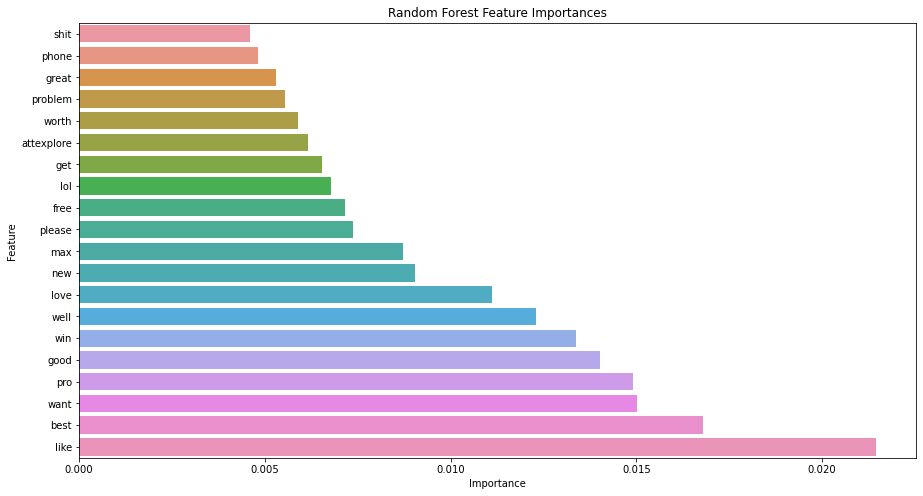

In [61]:
importances = sorted(list(zip(models[5].feature_importances_, vectorizer.get_feature_names())))[-20:]
plot = pd.DataFrame(importances, columns=['Importance', 'Feature'])

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=plot, y='Feature', x='Importance')
ax.set_title(f'{index[5]} Feature Importances')
plt.show();

In [62]:
words_dict = dict(zip(vectorizer.get_feature_names(), models[5].feature_importances_))

In [63]:
words_dict

{'aa': 3.0864280180582234e-05,
 'aaa': 1.6208608751511867e-05,
 'aaaaa': 8.657193648337691e-06,
 'aaaaaaaa': 2.2750656744022445e-07,
 'aaaaaaaaaa': 8.552673313798158e-07,
 'aaaaaahhhh': 2.884098971065982e-06,
 'aaaaand': 0.0,
 'aaaaat': 3.0073126480356064e-06,
 'aaaahhh': 3.8803685419983235e-06,
 'aaaamhim': 2.743950064521072e-06,
 'aaaggh': 8.267939947371226e-08,
 'aaalllennnndjsj': 2.2940458504194586e-09,
 'aabidahcrayola': 3.777946718290598e-09,
 'aachen': 3.895603304693258e-07,
 'aadh': 2.3215815779689045e-08,
 'aadiiii': 1.4881213977767398e-10,
 'aadilba': 2.1810572563273683e-07,
 'aagaya': 0.0,
 'aagazette': 3.0554997460973908e-09,
 'aah': 1.4134541187525871e-07,
 'aahe': 1.1918898596006592e-07,
 'aahh': 2.3207956503366257e-06,
 'aahhh': 1.2727418976422629e-06,
 'aail': 4.074500628926374e-07,
 'aaj': 1.4291530635595495e-08,
 'aaja': 5.885646286910946e-10,
 'aam': 4.425489322493069e-06,
 'aamaanil': 4.648367809810966e-09,
 'aameen': 2.9942537042749786e-07,
 'aamiin': 0.0,
 'aamirs

In [64]:
features_dict = dict((k, words_dict[k]) for k in ['battery', 'display', 'camera', 'pro', 'max', 'price', 'upgrade', 'color', 'screen'] if k in words_dict)

In [65]:
features_dict

{'battery': 0.0029178338033018503,
 'display': 0.0010140138013860556,
 'camera': 0.003483395357967188,
 'pro': 0.014911902851246104,
 'max': 0.008729106425143055,
 'price': 0.0009250825699217071,
 'upgrade': 0.0023830216113505695,
 'color': 0.0008971934450813305,
 'screen': 0.0016103016809383911}

In [66]:
features_df = pd.DataFrame(list(features_dict.items()), columns=['Feature', 'Importances'])

In [67]:
features_df

Feature  Importances
0  battery     0.002918
1  display     0.001014
2   camera     0.003483
3      pro     0.014912
4      max     0.008729
5    price     0.000925
6  upgrade     0.002383
7    color     0.000897
8   screen     0.001610

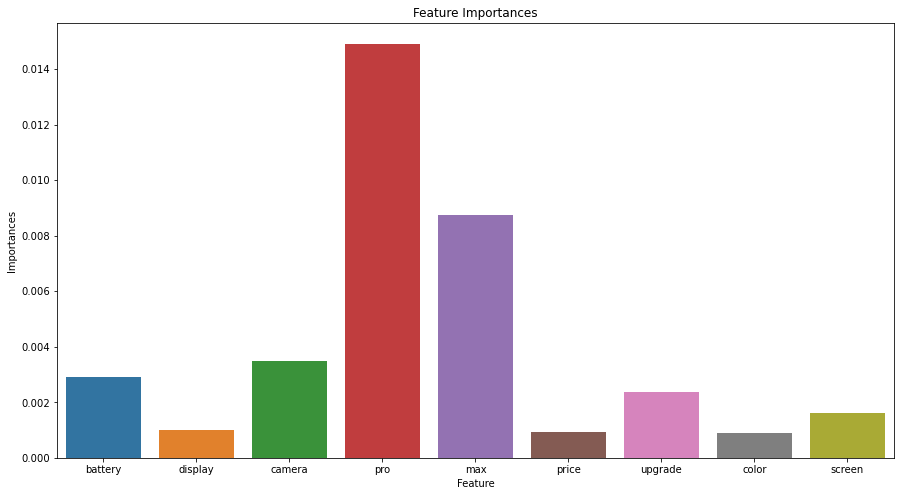

In [68]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=features_df, y='Importances', x='Feature')
ax.set_title('Feature Importances')
plt.show();

## Feature Importances Analysis

With the key features of the iPhone 13 now isolated, those selected words were then analyzed for positive and negative sentiment.

A count was done to see how many times each of those features appeared in both positive and negative tweets to determine whether consumers reacted positively or negatively to each one.

In [69]:
selected_words = ['battery', 'display', 'camera', 'pro', 'max', 'price', 'upgrade', 'color', 'screen']

In [70]:
positive_words_string = ' '.join([tweet for tweet in positive_df.clean_tweet])
positive_words_list = positive_words_string.split()

In [71]:
positive_words_list

['kind',
 'want',
 'fix',
 'unlock',
 'watch',
 'soon',
 'day',
 'silence',
 'sunday',
 'confirm',
 'unlock',
 'watch',
 'feature',
 'fix',
 'software',
 'patch',
 'support',
 'document',
 'publish',
 'sunday',
 'confirm',
 'issue',
 'limit',
 'unboxing',
 'let',
 'see',
 'video',
 'well',
 'twitter',
 'like',
 'ig',
 'tmartn',
 'hope',
 'giveaway',
 'much',
 'upcoming',
 'channel',
 'reach',
 'many',
 'people',
 'become',
 'part',
 'community',
 'well',
 'good',
 'luck',
 'everyone',
 'pro',
 'max',
 'company',
 'share',
 'crash',
 'announcement',
 'ok',
 'mean',
 'old',
 'model',
 'get',
 'cheap',
 'dog',
 'awesome',
 'normally',
 'run',
 'well',
 'almost',
 'device',
 'recently',
 'go',
 'full',
 'public',
 'release',
 'wait',
 'new',
 'pro',
 'max',
 'new',
 'ipad',
 'mini',
 'sixth',
 'generation',
 'use',
 'icloud',
 'backgup',
 'check',
 'order',
 'pro',
 'virginmedia',
 'make',
 'sure',
 'link',
 'broadband',
 'account',
 'order',
 'show',
 'already',
 'customer',
 'virginmobil

In [72]:
positive_dict_counts = Counter(positive_words_list)

In [73]:
positive_output_dict_counts = dict((k, positive_dict_counts[k]) for k in selected_words)

positive_output_dict_counts

{'battery': 1382,
 'display': 580,
 'camera': 2228,
 'pro': 13297,
 'max': 6059,
 'price': 458,
 'upgrade': 1028,
 'color': 558,
 'screen': 989}

In [74]:
plt.figure(figsize=(12,5))
plt.bar(range(len(positive_output_dict_counts)), positive_output_dict_counts.values(), align='center')
plt.xticks(range(len(positive_output_dict_counts)), list(positive_output_dict_counts.keys()), fontsize=13)
plt.title('Tweet Count for Positive Sentiment', fontsize=20)
plt.show()

In [75]:
negative_words_string = ' '.join([tweet for tweet in negative_df.clean_tweet])
negative_words_list = negative_words_string.split()

In [76]:
negative_words_list

['another',
 'huge',
 'distraction',
 'enemy',
 'well',
 'humble',
 'get',
 'flip',
 'phone',
 'lol',
 'promise',
 'fix',
 'broken',
 'unlock',
 'watch',
 'feature',
 'absolutely',
 'reason',
 'people',
 'buy',
 'cause',
 'really',
 'nothing',
 'promise',
 'fix',
 'broken',
 'unlock',
 'watch',
 'feature',
 'fix',
 'issue',
 'prevent',
 'user',
 'unlock',
 'watch',
 'upcoming',
 'software',
 'update',
 'face',
 'id',
 'stop',
 'work',
 'replace',
 'screen',
 'third',
 'party',
 'repair',
 'video',
 'fix',
 'issue',
 'prevent',
 'user',
 'unlock',
 'watch',
 'upcoming',
 'software',
 'update',
 'could',
 'absolutely',
 'care',
 'less',
 'cinematic',
 'mode',
 'whatever',
 'make',
 'round',
 'shitty',
 'focus',
 'pull',
 'mechanic',
 'cap',
 'p',
 'rendersbyian',
 'mac',
 'joseadorno',
 'real',
 'design',
 'buy',
 'second',
 'come',
 'go',
 'tbh',
 'name',
 'bubblepins',
 'get',
 'black',
 'pro',
 'fit',
 'color',
 'soul',
 'fix',
 'issue',
 'prevent',
 'user',
 'unlock',
 'watch',
 'upc

In [77]:
negative_dict_counts = Counter(negative_words_list)

In [78]:
negative_output_dict_counts = dict((k, negative_dict_counts[k]) for k in selected_words)

negative_output_dict_counts

{'battery': 440,
 'display': 147,
 'camera': 579,
 'pro': 3826,
 'max': 1931,
 'price': 189,
 'upgrade': 338,
 'color': 91,
 'screen': 415}

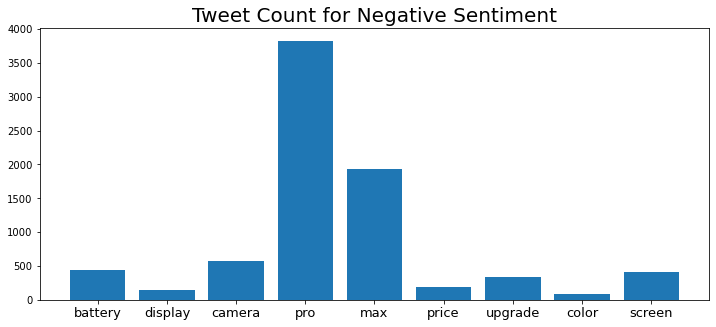

In [79]:
plt.figure(figsize=(12,5))
plt.bar(range(len(negative_output_dict_counts)), negative_output_dict_counts.values(), align='center')
plt.xticks(range(len(negative_output_dict_counts)), list(negative_output_dict_counts.keys()), fontsize=13)
plt.title('Tweet Count for Negative Sentiment', fontsize=20)
plt.show()

## Conclusions

* Overall reaction on the iPhone 13 was positive or neutral, showing that consumers were relatively pleased.

* The most talked about aspect of the iPhone on Twitter is pro and max, showing that consumers are reacting more to both the Pro and the Prox Max model of iPhone 13. This could mean that the features of those model, such as a larger screen and better camera, are favored by consumers.

* People are more focused on improvements to battery life and the camera and react accordingly.

* Upgrading is also talked about on Twitter and negative reactions to upgrading could be due to updated features.



## Future Recommendations

* Analysis of how Twitter sentiment affects stock market price could be looked at in order to get a better sense of how public opinion impacts Apple’s financial profile.

* Time series modeling could also be used to see how Twitter sentiment changes over time, as well as use that to compare with financial data.

* This analysis was just done over a two-week period immediately after release. Further analysis could be done over a longer period of time.

* Modeling Twitter sentiment is limited to current trends because of the Twitter API only allowing you to gather tweets that are seven days old. Historical Twitter data is no longer available.